# Analysis of intronic polyA sites
This notebook demostrates on how to create cutomized features. The examples is using intronic polyA annotations from the polyADB

In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/tscc/nfs/home/hsher/Metadensity/config/hg38-tscc2.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt


# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
%matplotlib inline

Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


In [2]:
# use katie's PCF11
katie_data = pd.read_csv('/home/hsher/projects/katie/katie_eclip.csv', index_col = 0)

In [3]:
# show a row of the csv file.
master_df.loc[master_df['RBP']=='CPSF6']

,uid,RBP,Cell line,bam_0,bam_1,bam_control,minus_0,minus_1,minus_control,plus_0,...,bed_0,bed_1,Batch,prefix,bam_control_0,bam_control_1,plus_control_0,plus_control_1,minus_control_0,minus_control_1
28,258,CPSF6,K562,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,...,/projects/ps-yeolab5/encode/EVN_eCLIP_analysis...,/projects/ps-yeolab5/encode/EVN_eCLIP_analysis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# show a row of the csv file.
katie_data.loc[katie_data['uid']=='PCF11']

,bam_0,bam_control_0,minus_0,minus_control_0,plus_0,plus_control_0,bed_0,bam_1,bam_control_1,minus_1,minus_control_1,plus_1,plus_control_1,bed_1,uid,RBP
0,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,/home/wjin/projects/CLIP_seq/Kris_Katie/Data/P...,PCF11,PCF11


In [5]:
# load each row the data file into an eCLIP Object
U2AF1 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'U2AF1')&(encode_data['Cell line'] == 'HepG2')].iloc[0], single_end = False)
U2AF2 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'U2AF2')&(encode_data['Cell line'] == 'HepG2')].iloc[0], single_end = False)
SF3B4 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'SF3B4')&(encode_data['Cell line'] == 'HepG2')].iloc[0], single_end = False)
NONO = eCLIP.from_series(encode4_data.loc[(encode4_data['RBP'] == 'NONO')&(encode4_data['Cell line'] == 'HepG2')].iloc[0], single_end = True)
CPSF6 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'CPSF6')&(encode_data['Cell line'] == 'K562')].iloc[0], single_end = False)
PCF11 = eCLIP.from_series(katie_data.loc[katie_data['uid']=='PCF11'].iloc[0], single_end = True)
all_clips = [U2AF1,U2AF2,SF3B4, NONO,CPSF6, PCF11]

## Creating custom  features on metagene, using intronic polyA sites as an example

In [45]:
os.path.join(settings.root_dir, settings.polya_fname)

'/home/hsher/gencode_coords/polyA.atlas.clusters.2.0.GRCh38.96.bed'

In [29]:
# load polyA sites files
# (in order of decreasing priority: TE, terminal exon; EX, exonic; IN, intronic; DS, 1,000 nt downstream of an annotated terminal exon; AE, anti-sense to an exon; AI, anti-sense to an intron; AU, 1,000 nt upstream in anti-sense direction of a transcription start site; IG, intergenic)
polyadf = pd.read_csv(os.path.join(settings.root_dir, settings.polya_fname), sep = '\t', header = None, names = ['chrom', 'start', 'end', 'name', 'average expression', 'strand', 'perc_sample','n_sample', 'avg_tpm', 'polyatype', 'polyasignal'])
#  two letter code for the cluster annotation (in order of decreasing priority: 
# TE, terminal exon; EX, exonic; IN, intronic; DS, 1,000 nt downstream of an annotated terminal exon; AE, anti-sense to an exon; AI, anti-sense to an intron; AU, 1,000 nt upstream in anti-sense direction of a transcription start site; IG, intergenic)
# the chromosome is listed differently
polyadf['chrom'] = 'chr'+polyadf['chrom'].astype(str)

# filter with TPM at least 0.2
polyadf = polyadf.loc[polyadf['average expression']>0.2]

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
# make type specific annotation
def extract_polyA_signal_coordinates(subset_polyadf):
    ''' subtracting the coordinate of polyA signal from polya dataframe'''
    # extract polya signals
    signal_coord = []
    for index, row in subset_polyadf.iterrows():
        if type(row['polyasignal'])==str:
            polyasignals = row['polyasignal'].split(';')
            for sig in polyasignals:
                motif, rela_pos, obs_pos = sig.split('@')
                signal_coord.append([row['chrom'],int(obs_pos),int(obs_pos)+1, 
                                     row['name'], row['polyatype'], row['strand']])

    # make into bed
    polysignal_df = pd.DataFrame(signal_coord,
                                columns= ['chrom', 'start', 'end', 'name', 'score', 'strand'])
    polyasignal_bed = BedTool.from_dataframe(polysignal_df)

    return polyasignal_bed
def polyAtype_specific_coords(polyAtype, polyadf = polyadf):
    ''' create polyA related feature for specific types of polyA
    polyAtype can be TE, EX, IN, DS..'''
    # filter for specific types
    subset_polyadf = polyadf.loc[polyadf['polyatype']==polyAtype]
    
    # create bed of polyA sites
    polya_site_bed = BedTool.from_dataframe(subset_polyadf)
    polya_signal_bed = extract_polyA_signal_coordinates(subset_polyadf)
    
    return polya_site_bed, polya_signal_bed

In [30]:
# extract intronic polyA sites and signal
#information about the poly(A) signal(s) that are present upstream of the poly(A) site, 
#including the motif, the location with respect to the cleavage site and the genomic coordinate

polya, polyasignal_bed = polyAtype_specific_coords('IN', polyadf = polyadf)

In [31]:
# determine which transcript these are in
header = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'attr']
polya_site_df = polya.intersect(transcript,s = True, wb = True).to_dataframe(header = None)[[0,1,2,3,4,5,19]]
polysignal_df = polyasignal_bed.intersect(transcript, s = True, wb = True).to_dataframe(header = None)[[0,1,2,3,4,5,14]]
polya_site_df.columns = header
polysignal_df.columns = header

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/pybedtools-0.8.1-py3.7-linux-x86_64.egg/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 20 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())
/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/pybedtools-0.8.1-py3.7-linux-x86_64.egg/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 15 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [34]:
# extract transcript name
def segment_transcript_name(s):
    return s.split(';')[0].split('=')[1]
polysignal_df['transcript_id']= polysignal_df['attr'].map(segment_transcript_name)
polya_site_df['transcript_id']= polya_site_df['attr'].map(segment_transcript_name)

## Building Metagene objects containing intronic polyA sites
Now we know where these sites are, and we know what transcripts they are in.
The next step is to add the polyA site features into metagene objects.

In [35]:
# build metagene from highly expressed in HepG2 cell lines
from metadensity.pos_enrich import *
high_exp_meta = highly_exp_biogps('HEPG2')

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Using: /home/hsher/Metadensity/metadensity/data/hg38/gencode
Done building metagene


In [36]:
# check how many of those highly expressed contain intronic polya sites
polya_site_df.loc[polya_site_df['transcript_id'].isin(high_exp_meta.keys())].shape

(51, 8)

In [37]:
# add feature to those metagene
length = 200
for transcript_id in high_exp_meta.keys():
    metagene = high_exp_meta[transcript_id]
    
    # add feature
    sub = polya_site_df.loc[polya_site_df['transcript_id']==transcript_id]
    for index, row in sub.iterrows():
        metagene.create_feature(interval = row['start'], feature_name = 'intron_polyAsite',
                                length = 200
                               ) # POINT FEATURE
    
    sub = polysignal_df.loc[polysignal_df['transcript_id']==transcript_id]
    for index, row in sub.iterrows():
        metagene.create_feature(interval = row['start'], feature_name = 'intron_polyAsig',
                               length = 200)

In [38]:
# remove metagene that has no intronic polya
for transcript_id in list(high_exp_meta.keys()).copy():
    metagene = high_exp_meta[transcript_id]
    
    if 'intron_polyAsite' not in metagene.featnames or 'intron_polyAsig' not in metagene.featnames:
        del high_exp_meta[transcript_id]

In [39]:
# we get a total of 147 transcripts with annotation
len(high_exp_meta)

34

## extract density from eCLIP
The `Metadensity` Object takes in `eCLIP` and the `metagene` we just built with polyA sites, and fetch density around/within each features

In [40]:
def build_idr_metadensity(eCLIP, metagene = high_exp_meta):
    ''' build metadensity object given eCLIP data and metagene that is build with intronic polyA sites'''
    
    m = Metadensity(eCLIP, eCLIP.name, metagenes = metagene,
                   background_method = 'relative information', normalize = False)
    m.featnames = ['intron_polyAsig','intron_polyAsite'] # to restrict only computing for these 2 features
    m.get_density_array()
    return m

In [41]:
# do it for all eCLIP objects
all_meta = [build_idr_metadensity(e) for e in all_clips]


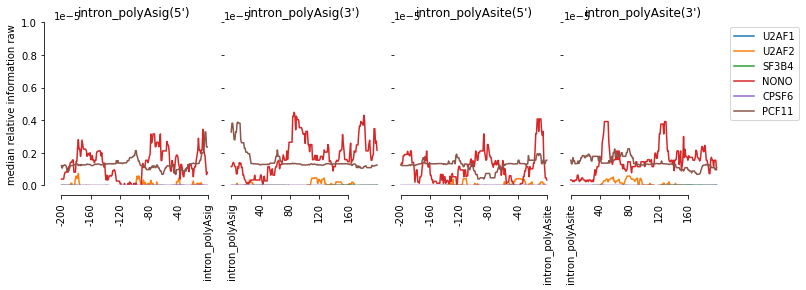

In [62]:
# visualize it
f=plot_mean_density(all_meta,
                    features_to_show = ['intron_polyAsig','intron_polyAsite'], 
                    ymax = 0.00001, stat = 'median',plot_std = False)
f=beautify(f)

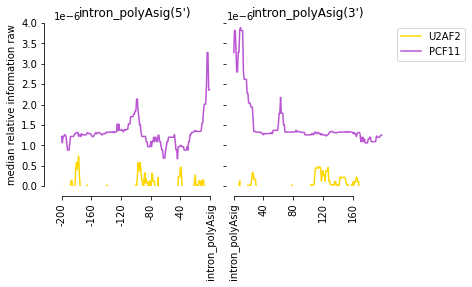

In [61]:
f=plot_mean_density([m for m in all_meta if m.name=='PCF11' 
                     or m.name == 'U2AF2'],
                    features_to_show = ['intron_polyAsig'], 
                    ymax = 0.000004, stat = 'median', plot_std = False,
                   color_dict = {'PCF11':'mediumorchid', 'U2AF2':'gold'})
f=beautify(f)

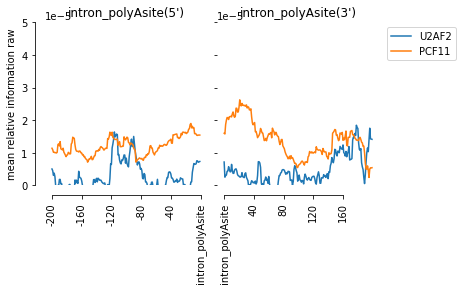

In [56]:
f=plot_mean_density([m for m in all_meta if m.name=='PCF11' or m.name == 'U2AF2'],
                    features_to_show = ['intron_polyAsite'], 
                    ymax = 0.00005, stat = 'mean', plot_std = False)
f=beautify(f)

In [19]:
all_meta[0].metagene['ENST00000377577.10'].features['intron_polyAsite']

{6647112,
 6649008,
 6652407,
 6653154,
 6672178,
 6674099,
 6691311,
 6692044,
 6693824,
 6700965}

In [20]:
settings.point_feature_len

50

In [21]:
settings.feat_len

defaultdict(<function metadensity.config.MetadensityConfig.__init__.<locals>.<lambda>()>,
            {'five_prime_UTR': 100,
             'three_prime_UTR': 150,
             'intron': 500,
             'exon': 100,
             'first_exon': 100,
             'last_exon': 100,
             'CDS': 100,
             'first_CDS': 100,
             'last_CDS': 100,
             '3p_duplex': 20,
             '5p_duplex': 20,
             'mature': 20,
             'hairpin': 10,
             'pri_mir': 500,
             'start_codon': 3,
             'stop_codon': 3,
             'branchpoint': 50,
             'branchpoint_pred': 50,
             'full_CDS': 200,
             'intron_polyAsite': 200,
             'intron_polyAsig': 200})

In [30]:
m=all_meta[0].metagene['ENST00000377577.10']
m.features.keys()

dict_keys(['exon', 'CDS', 'start_codon', 'stop_codon', 'five_prime_UTR', 'three_prime_UTR', 'intron', 'branchpoint', 'branchpoint_pred', 'last_exon', 'first_exon', 'last_CDS', 'first_CDS', 'intron_polyAsite', 'intron_polyAsig'])

In [23]:
len(m.densities['282']['rep1']['intron_polyAsite'])

400